### Plotting winds and sea-ice speed along transect in the Beaufort Sea from neXtSIM experiments
#### Author: Jonathan Rheinlænder*
#### Date: Aug. 27 2021
#### Affiliation: Nansen Environmental and Remote Sensing Center, Bergen, Norway
*jonathan.rheinlaender@nersc.no

In [1]:
# allow plots to be interactive in the notebook
%matplotlib notebook
import numpy as np
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from pathlib import Path  
import sys
import xarray as xr
import matplotlib.colors as colors
import cartopy 
import cartopy.crs as ccrs
import pyproj
import matplotlib.gridspec as gridspec
import cmocean
import argparse
import locale 
import matplotlib.ticker as mticker

In [12]:
def get_transect(xr, start_time, end_time, xpoint, ypoint):

    time_slice = slice(start_time, end_time)
    x_slice = xpoint[0]
    y_slice = slice(ypoint[0], ypoint[1])

    transect = xr.sel(time=time_slice, x=x_slice, y=y_slice)

    # make array of datetime objects
    vtimes = transect.time.values.astype('datetime64[ms]').astype('O')

    # Specify y values for transect
    length = y_slice.stop - y_slice.start
    res = 5 # 5 km grid spacing
    ydist = np.arange(0,length*res, res) # distance in km from Banks Island (y0)
    
    print(ydist.shape, vtimes.shape, transect.shape)

    return ydist, vtimes, transect

def plot_map(ax):

    lons = ds.longitude[:] #dims:y,x
    lats = ds.latitude[:]

    # find lon,lat coordinates for x,y points
    lon0 = lons[ypoint[0]][xpoint[0]]
    lon1 = lons[ypoint[1]][xpoint[1]]
    lat0 = lats[ypoint[0]][xpoint[0]]
    lat1 = lats[ypoint[1]][xpoint[1]]
    lon = (lon0, lon1)
    lat = (lat0, lat1)
    
    proj = ccrs.NorthPolarStereo(central_longitude=-45)
    ax.set_extent([-2611832.880671568, -369765.49428808136, -1058480.3928495955, 1951306.484993737], crs=ax.projection) 

    ax.add_feature(cartopy.feature.LAND,zorder=1,alpha=1, color="lightgrey") 
    ax.coastlines(resolution='50m', linewidth=0.5) 
    ax.gridlines(draw_labels=False, linestyle='--', alpha=0.5,  linewidth=0.3)
    ax.plot(lon, lat, 'ro-',linewidth=1, markersize=3, transform=ccrs.Geodetic()) # geodetic plots shortest distance 
#    ax.patch.set_alpha(0.7)

def plot_transect(ax, vname, add_insetmap=True):
    global clabel, figname, cmap, clim, cb_extend, zlev
    clabel, figname, cmap, clim, cb_extend, zlev = _PLOT_INFO[vname]
    
    print("Start plotting", vname)
    #fig = plt.figure(figsize=(8, 3))
    #fig.subplots_adjust(bottom=0.2, top=0.90, left=0.1, right=0.95, wspace=0.01, hspace=0.01)
    #ax = fig.add_subplot(111)
    
    if np.size(clim)==2: #contineous colormap 
        cf = ax.contourf(vtimes, yvals, transect.transpose(), 
        vmin=clim[0], vmax=clim[1], cmap=cmap, extend=cb_extend)
    else: #discrete colormap
        clevs = np.arange(clim[0], clim[1]+clim[2],clim[2])
        cf = ax.contourf(vtimes, yvals, transect.transpose(), 
            levels=clevs, cmap=cmap, extend=cb_extend)

    # add single contour line
    cline = ax.contour(vtimes, yvals, transect.transpose(), levels=zlev,  colors='k', linewidths=0.5)
    
    # add colorbar
   # cbar = plt.colorbar(cf, ax=ax, orientation='vertical', pad=0.02, aspect=40)
    #cbar.set_label(clabel)  
    pos = ax.get_position() 
    cax = fig.add_axes([pos.xmax+.015, pos.y0, 0.01, pos.ymax-pos.y0 ])
    cbar=fig.colorbar(cf,cax=cax)
    cbar.set_label(clabel)
    
    # set labels
    locale.setlocale(locale.LC_ALL,'en_US')  # change language to EN
    days = mdates.DayLocator()  # every day
    dtFmt = mdates.DateFormatter('%b %d') # define the formatting 
    ax.xaxis.set_major_formatter(dtFmt)
    ax.xaxis.set_minor_locator(days)
    #plt.xticks(rotation=45) # rotate xlabels
    ax.set_ylabel("y")

    # add map 
    if add_insetmap:
        proj = ccrs.NorthPolarStereo(central_longitude=-45)
        ax_inset = fig.add_axes([pos.x0-.015, pos.y0+.01, 0.18, 0.2], projection=proj)
        plot_map(ax_inset) 
        
def plot_vectors(ax, ds):
    
    time = ds['time']
    u = ds['wndx']
    v = ds['wndy']

    # calculate the magnitude
    scale=2
    magnitude = (u**2 + v**2)**0.5
    maxmag = max(magnitude)/scale
    ax.set_ylim(-maxmag, maxmag)
    xint = 2 # set interval
    q = ax.quiver(time[::xint], 0, u[::xint],v[::xint],  
           color='r',
           units='y',
           scale_units='y',
           scale = 2,
           headlength=2,
           headaxislength=2,
           width=0.2,
           alpha=1
              )

    qk = plt.quiverkey(q,0.17, 0.2, 10,
               r' 10 m s$^{-1}$',
               labelpos='W',
               fontproperties={'weight': 'normal'})

    # Fake 'box' to be able to insert a legend'
#    p = ax.add_patch(plt.Rectangle((1,1),1,1,fc='w',alpha=1))
#    leg1 = ax.legend([p], ["[x, y]=" + "["+str(xloc)+", "+str(yloc)+"]"],loc='lower right')
#    leg1._drawFrame=False

    # add horizontal line at y=0
    ax.axhline(linewidth=1, color='grey', alpha=0.2)

    ax.set_xlim(min(time),max(time))
    ax.set_yticklabels([])


In [4]:
# main

# create dictionary for plotting different variables
_PLOT_INFO =dict(
    wspeed = ('Wind speed (m s$^{-1}$)', 'wspeed_transect_beaufort','RdYlBu_r', [0,20,1], 'max', [10]),
    icevel = ('Ice velocity (cm s$^{-1}$)', 'icevel_transect_beaufort', cmocean.cm.speed, [0, 40, 2], 'max', [5]),    
)

outdir =  '/cluster/home/rheinlender/projects/aoi_case_study/python/breakup-paper/figs/'
inpath ='/cluster/projects/nn9624k/rheinlender/breakup2013/data/wrf-exp/start_20130213_nudging/'
expts = ["expt_01_wrf10/outputs-v11/", "expt_04_wrf80/outputs/"]
expts_names = "wrf10"

# Create slice variables subset domain
vname=['wspeed', 'icevel']
start_time = '2013-02-11'
end_time = '2013-03-13'
xpoint = (100, 100)
ypoint = (180, 450)

files = [os.path.join(inpath, f, 'Moorings.nc') for f in expts]
#fl = inpath + expts[:] + 'Moorings.nc'
print("loading", files)

ds10 = xr.load_dataset(files[0]) # wrf10
ds80 = xr.load_dataset(files[1]) # wrf80

for ds in [ds10, ds80]:
    # calculate ice velocity 
    ds['icevel'] = (ds['siu']**2 + ds['siv']**2)**0.5
    ds['icevel'] = ds['icevel']*100 # convert to cm/s
    ds['icevel'].attrs["units"] = "cm s$^{-1}$"


loading ['/cluster/projects/nn9624k/rheinlender/breakup2013/data/wrf-exp/start_20130213_nudging/expt_01_wrf10/outputs-v11/Moorings.nc', '/cluster/projects/nn9624k/rheinlender/breakup2013/data/wrf-exp/start_20130213_nudging/expt_04_wrf80/outputs/Moorings.nc']


<IPython.core.display.Javascript object>


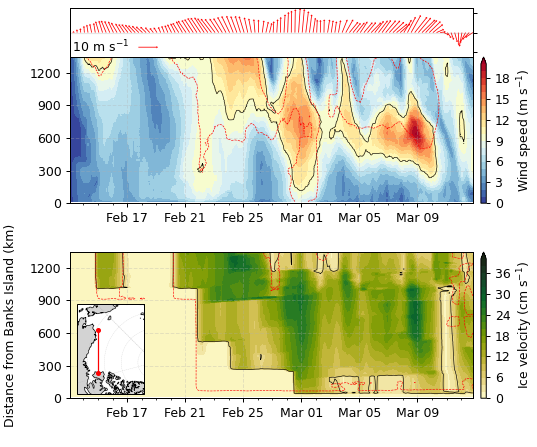

Get transect for  wspeed
(270,) (223,) (223, 270)
0 0
Start plotting wspeed
Get transect for  icevel
(270,) (223,) (223, 270)
1 0
Start plotting icevel
Get transect for  wspeed
(270,) (223,) (223, 270)
0 1
Get transect for  icevel
(270,) (223,) (223, 270)
1 1
Saving /cluster/home/rheinlender/projects/aoi_case_study/python/breakup-paper/figs/wspeed_icevel_transect_beaufort_20130213-20130312_wrf10.png


In [19]:
# Make the plot

plt.close('all')
fig = plt.figure(figsize=(6,5)) #create one of the figures that must appear with the chart
gs = gridspec.GridSpec(9,1)
ax0 = fig.add_subplot(gs[0, 0]) 
ax1 = fig.add_subplot(gs[1:4, 0]) # top: for wspeed
ax2 = fig.add_subplot(gs[5:8, 0]) # bottom: for velocity 
axlist = [ax1, ax2]

fig.subplots_adjust(bottom=0.0, top=0.98, left=0.13, right=0.88, wspace=0.08, hspace=0.0001)
plt.show()

i=0
for n, ds in enumerate([ds10, ds80]):
    

    for i, var in enumerate(vname):
        print("Get transect for ", var)
        yvals, vtimes, transect = get_transect(ds[var] ,start_time, end_time, xpoint, ypoint)
        print(i,n)
        ax=axlist[i]
        if i==0:    # upper subplot
            
            if n==1: # WRF80 - single contour of the 10m/s wspeed
                cline = ax.contour(vtimes, yvals, transect.transpose(), levels=[10],  colors='r', linestyles='--',linewidths=0.5)
                
            else:

                # plot avg winds along transect
                xloc=100;
                yloc=310;                
                ds_sel = ds.sel(x=xpoint[0], y=slice(ypoint[0], ypoint[1])).mean(dim=('y')).squeeze()

                plot_vectors(ax0, ds_sel)
                ax0.yaxis.set_ticks_position("right")   #set y-axis on right
                ax0.yaxis.set_label_position("right")


                plot_transect(ax, var, add_insetmap=False)  

        elif i==1: # lower subplot
            if n==1: # WRF80 - single contour of the 10m/s wspeed
                cline = ax.contour(vtimes, yvals, transect.transpose(), levels=zlev,  
                                   colors='r', linestyles='--',linewidths=0.5)
                
            else:
                plot_transect(ax, var, add_insetmap=True)  

        # label stuff
        ax.set_ylabel((''))
        ax.yaxis.set_ticks(np.arange(yvals[0], yvals[-1], step=300))  # Set label locations.
        ax.grid(linestyle='--', alpha=0.3)
        #i+=1

ax0.set_xticklabels([])
ax2.set_ylabel('Distance from Banks Island (km)', labelpad=10)

# arrows in ylabel
#ax1.yaxis.set_minor_locator(mticker.FixedLocator([ypoint[0]+65, ypoint[1]-60]))
#ax1.yaxis.set_minor_formatter(mticker.FixedFormatter((r'$\longleftarrow$B. Island.', r'P. Barrow$\longrightarrow$')))
#plt.setp(ax1.yaxis.get_minorticklabels(), rotation=90, size=10, va="center")
#ax1.tick_params("y",which="minor",pad=30, left=False)     

#fig.subplots_adjust(bottom=0.0, top=0.98, left=0.08, right=0.9, wspace=0.08, hspace=0.0001)
plt.show()

# save figure
figname = os.path.join(outdir,
      '%s_%s-%s_%s' % ('wspeed_icevel_transect_beaufort', vtimes[0].strftime('%Y%m%d'), vtimes[-1].strftime('%Y%m%d'),expts_names))
figname = figname + '.png'
os.makedirs(os.path.dirname(figname), exist_ok=True)
print(f'Saving {figname}')
#fig.savefig(figname, dpi=300, bbox_inches='tight')
